### Heartbeat Arrhythmia Detection with Convolutional Neural Networks at MIT-BIH dataset
---
##### Part1
---
###### * Downloading dataset
###### * File manipulation

In [1]:
# Importing built-in libraries
import os
import glob

# Importing WFDB library for getting data
from wfdb.io import get_dbs
from wfdb.io import dl_database

In [2]:
# Change current working directory
print("Directory before changing it: " + os.getcwd())
os.chdir("..")
print("Directory after changing it: " + os.getcwd())

Directory before changing it: /home/ferhat/PycharmProjects/arrhythmia-cnn/notebooks
Directory after changing it: /home/ferhat/PycharmProjects/arrhythmia-cnn


In [3]:
# Download data if it's not exist in data directory,
# otherwise download it from PhysioNet

if not os.path.exists("data/mitdb"):
    dbs = get_dbs()
    print(dbs)

    subs = 'MIT-BIH'
    res = [[index, sub_string] for index, sub_string in enumerate(dbs) if subs in sub_string[1]]
    print(res)
    os.mkdir("data/mitdb")
    dl_database('mitdb', dl_dir='data/mitdb')
else:
    print("Data directory exists")

Data directory exists


In [4]:
def get_file_paths():
    # Getting paths for records and annotations
    record_paths = glob.glob("data/mitdb/*.dat")
    annot_paths = glob.glob("data/mitdb/*.atr")
    hea_paths = glob.glob("data/mitdb/*.hea")

    # Sort lists
    record_paths.sort()
    annot_paths.sort()
    hea_paths.sort()
    # Create path dict
    p = {"rec_path": record_paths,
         "ann_path": annot_paths,
         "hea_path": hea_paths}

    return p

paths = get_file_paths()
# Throws error if total data file number is not equeal to other specs
try:
    if len(paths["rec_path"]) != len(paths["ann_path"]) != len(paths["hea_path"]):
        raise IOError

except IOError:
    print("Some data files are missing!")

In [5]:
# Importing WFDB plot functions, uses Matplotlib
from wfdb.io import rdann, rdrecord
from wfdb.plot import plot_wfdb

# Read 2 channel record and it's annotation
record = rdrecord(paths["rec_path"][0].split(".")[0], sampto=3000)
ann = rdann(paths["ann_path"][0].split(".")[0], "atr", sampto=3000)

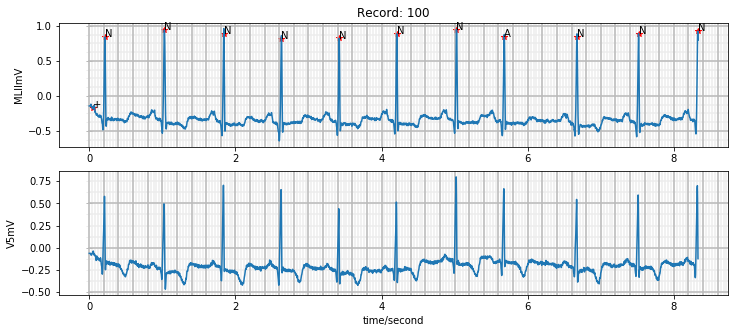

In [6]:
# Plot graph with grids
plot_wfdb(record=record, annotation=ann, plot_sym=True,
          time_units='seconds',
          figsize=(12, 5), ecg_grids='all')

In [7]:
# Import beat dictionary
from data import beat_ann

def get_beat_count_dict():
    # Create empty dictionary to hold all count values
    bc_dict = {}
    # Take all patients in annotation lists
    for patient in range(len(paths["ann_path"])):
        annot = rdann(paths["ann_path"][patient].split(".")[0], "atr")
        # Take all beats
        for beat_type in annot.symbol:
            # Check if beat type is in pre-defined beat dictionary
            if beat_type in beat_ann:
                # If dictionary does not include that beat type create a key-value pair and assign to 1
                if beat_type not in bc_dict.keys():
                    bc_dict[beat_type] = 1
                # Otherwise add 1 to value of matched beat type
                else:
                    bc_dict[beat_type] += 1

    return bc_dict

beat_count_dict = get_beat_count_dict()

In [8]:
# Importing NumPy
import numpy as np
from data import b_to_sb

def get_sb_list():
    sbl = []
    count_labels, count_values = np.array(list(beat_count_dict.items())).T

    for beat_type in list(b_to_sb.keys()):
        sbl.append([beat_type,
                        count_values[list(count_labels).index(beat_type)],
                        b_to_sb[beat_type]])

    # List contains beat types, beat counts and super beat classes according to its order
    sbl = np.array(sbl)
    return sbl

sb_list = get_sb_list()

In [9]:
# Importing Seaborn and Matplotlib.PyPlot to plot graphs
import seaborn as sns
import matplotlib.pyplot as plt
# Importing Matplotlib.Patches to create custom legends
import matplotlib.patches as mpatches

# Importing only super class names
from data import sb_ann_palette, sb_ann_class, sb_ann_class_palette, sb_ann

---
##### Part 2
---
###### * Ploting raw data (Bar plot, pie chart etc.)
###### * Data analysis

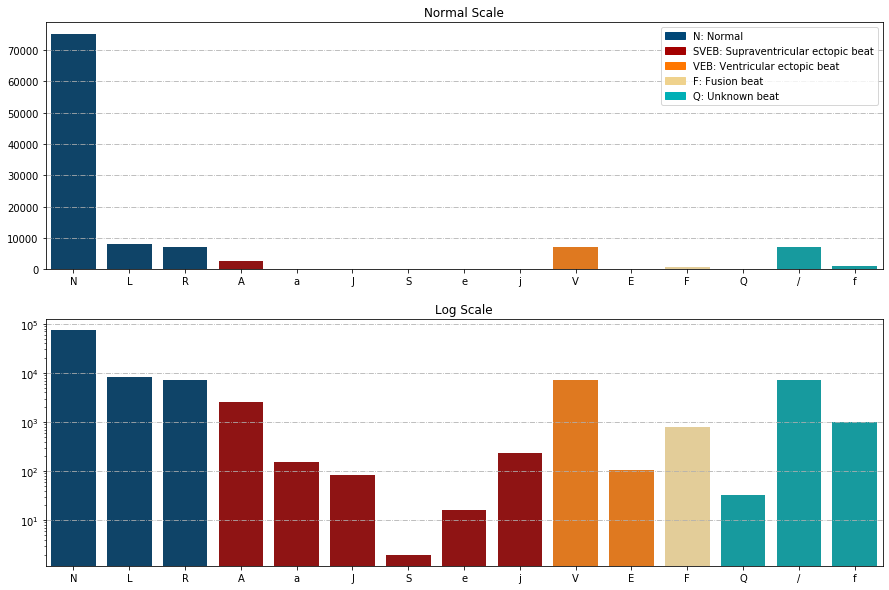

In [10]:
# Creating bar plot figure with specified size
def draw_barplot_sb_class():
    fig, (norm_ax, log_ax) = plt.subplots(2, figsize=(15, 10))
    # Defining legend patches for superior arrythmia classes
    patch_list = [mpatches.Patch(color=p, label=l + ": " + sb_ann[l]) for p, l in zip(sb_ann_class_palette, sb_ann_class)]

    sns.barplot(sb_list[:, 0], sb_list[:, 1], palette=sb_ann_palette, ax=norm_ax)
    # Setting y-axis to normal scale and adding horizontal grid
    norm_ax.grid(True, axis="y", which="major", ls="-.")
    norm_ax.set_title("Normal Scale")
    # Implementing custom legend
    _ = norm_ax.legend(handles=patch_list)
    # Show the plot

    # Ploting bar plot with seaborn
    sns.barplot(sb_list[:, 0], sb_list[:, 1], palette=sb_ann_palette, ax=log_ax)
    # Setting y-axis to logarithmic scale and adding horizontal grid
    log_ax.set_yscale("log")
    log_ax.grid(True, axis="y", which="major", ls="-.")
    log_ax.set_title("Log Scale")

    plt.show()

draw_barplot_sb_class()

In [21]:
# Printing beat names and counts
print("Instance Count\t|\tAnnotation (Super Beat)")
for i, c, s in np.array(sb_list[:,:]):
    print(f"{c}\t\t|\t{i}: {beat_ann[i]} ({s})")

Instance Count	|	Annotation (Super Beat)
75052		|	N: Normal beat (N)
8075		|	L: Left bundle branch block beat (N)
7259		|	R: Right bundle branch block beat (N)
2546		|	A: Atrial premature beat (SVEB)
150		|	a: Aberrated atrial premature beat (SVEB)
83		|	J: Nodal (junctional) premature beat} (SVEB)
2		|	S: Supraventricular premature or ectopic beat (atrial or nodal) (SVEB)
16		|	e: Atrial escape beat (SVEB)
229		|	j: Nodal (junctional) escape beat (SVEB)
7130		|	V: Premature ventricular contraction (VEB)
106		|	E: Ventricular escape beat (VEB)
803		|	F: Fusion of ventricular and normal beat (F)
33		|	Q: Unclassifiable beat (Q)
7028		|	/: Paced beat (Q)
982		|	f: Fusion of paced and normal beat (Q)


In [12]:
# Calculate total super beat instances
def get_sb_instances():
    sbeat_count_dict = {}
    for sb in sb_ann_class:
        cnt = 0
        for c, b in np.array(sb_list)[:, 1:]:
            if sb == b:
                cnt += int(c)
        sbeat_count_dict[sb] = cnt

    return sbeat_count_dict

sb_count_dict = get_sb_instances()

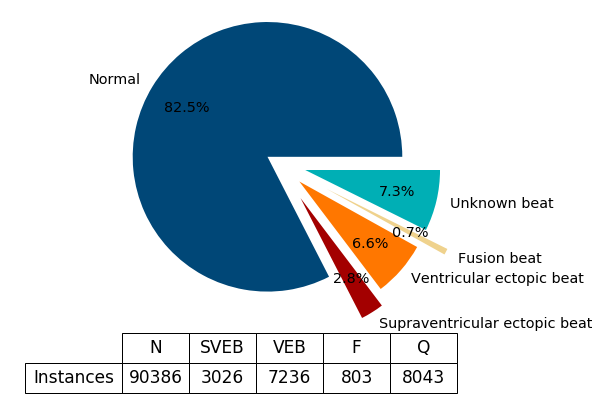

In [13]:
# Creating pie chart figure with specified size
def draw_pie_chart_sb_class():
    # Set figure size
    plt.figure(figsize=(6, 6))
    # Total suber beat class instances
    total = sum(list(sb_count_dict.values()))
    # Divide all suber beat class instances to total beat number to define pie chart percentage row values
    sizes = [(size / total) * 100 for size in list(sb_count_dict.values())]
    # Set pie chart class parts explode
    explode = (0.1, 0.3, 0.2, 0.4, 0.2)
    # Draw pie chart
    plt.pie(sizes, explode=explode, labels=list(sb_ann.values()), autopct='%1.1f%%',
            pctdistance=0.7, textprops={"fontsize": "x-large"}, colors=sb_ann_class_palette,
            shadow=False, startangle=0)
    # Setting all axis to equal to get perfect circular pie chart
    plt.axis('equal')
    # Define row values of table plot
    rows = [[str(integer) for integer in list(sb_count_dict.values())]]
    row_label = ["Instances"]
    # Defining column headers of table plot
    cols = tuple(sb_count_dict.keys())
    # Draw table
    table = plt.table(cellText=rows,
                      colLabels=cols,
                      rowLabels=row_label,
                      loc="bottom",
                      cellLoc="center",
                      rowLoc="center",
                      colLoc="center")
    # Scale table and font size
    table.scale(1, 2.5)
    table.set_fontsize(20)
    # Show the plot
    plt.show()

draw_pie_chart_sb_class()

---
##### Part 3
---
###### * Data splitting
###### * Data randomize